In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = f17e0b2
conc = na
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

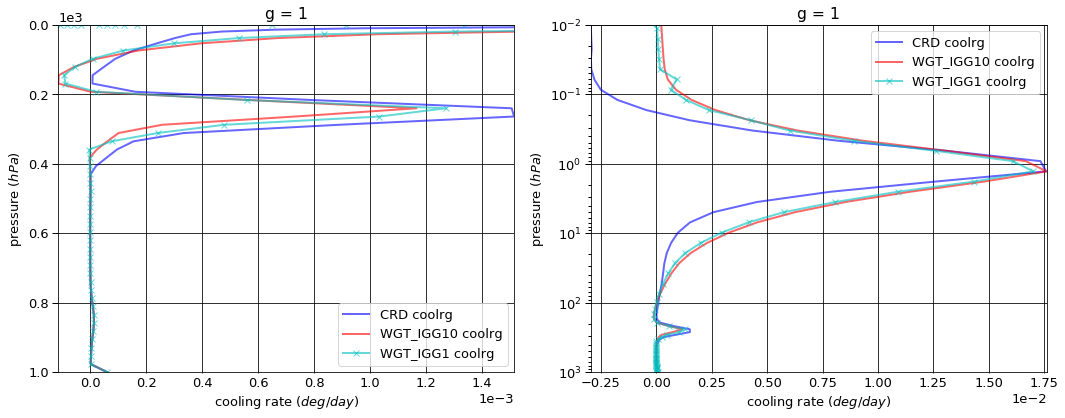

# Figure: cooling rate g-group 2

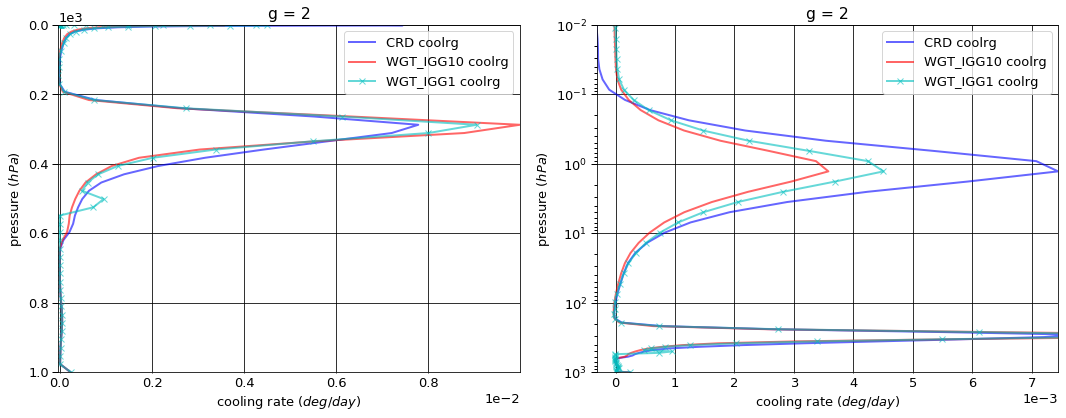

# Figure: cooling rate g-group 3

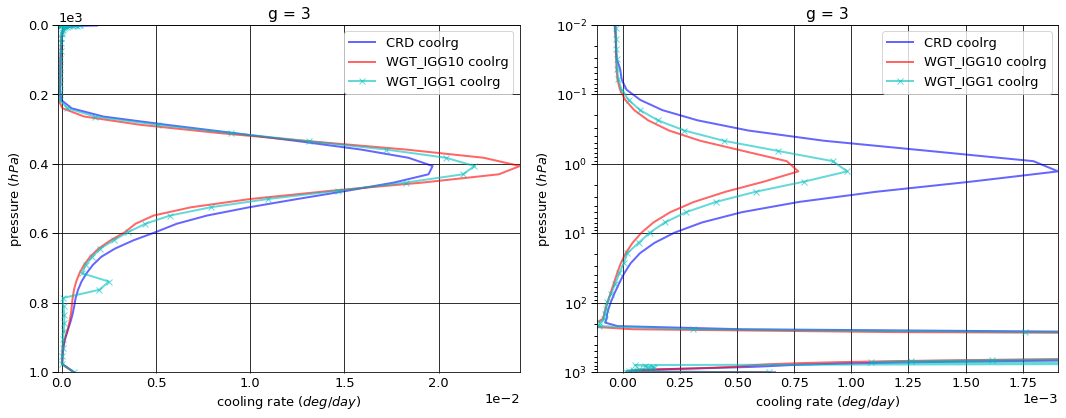

# Figure: cooling rate g-group 4

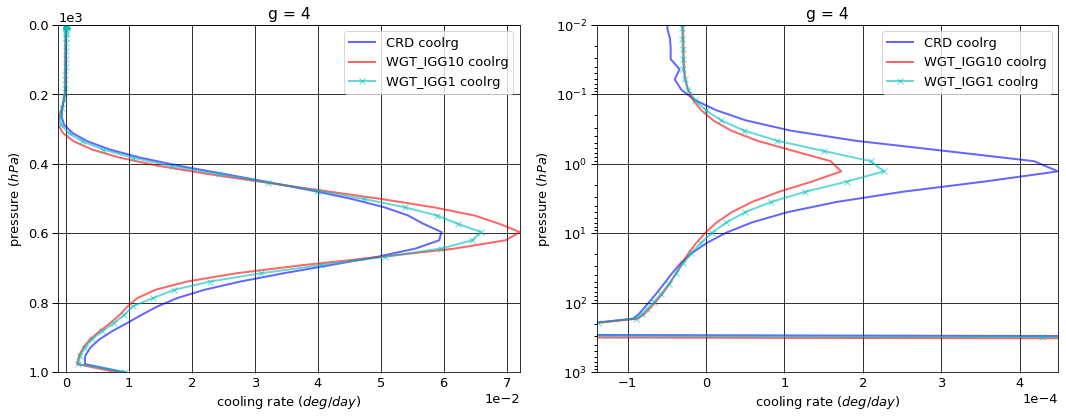

# Figure: cooling rate g-group 5

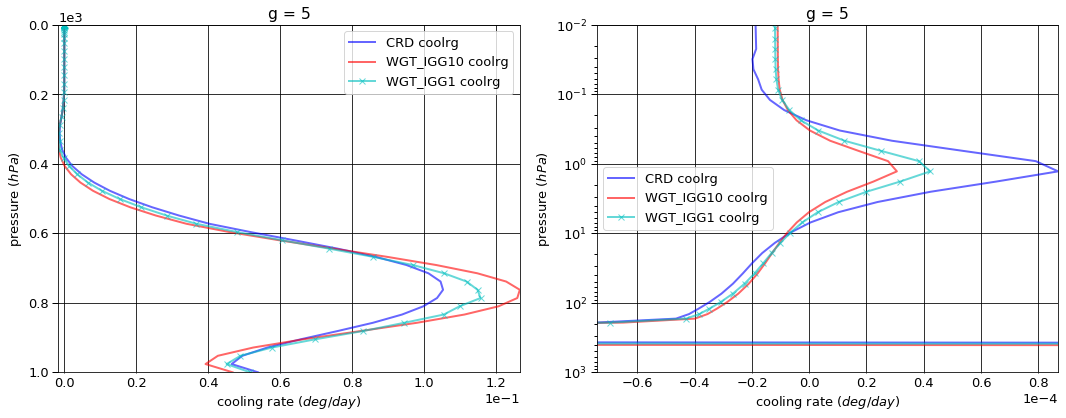

# Figure: cooling rate g-group 6

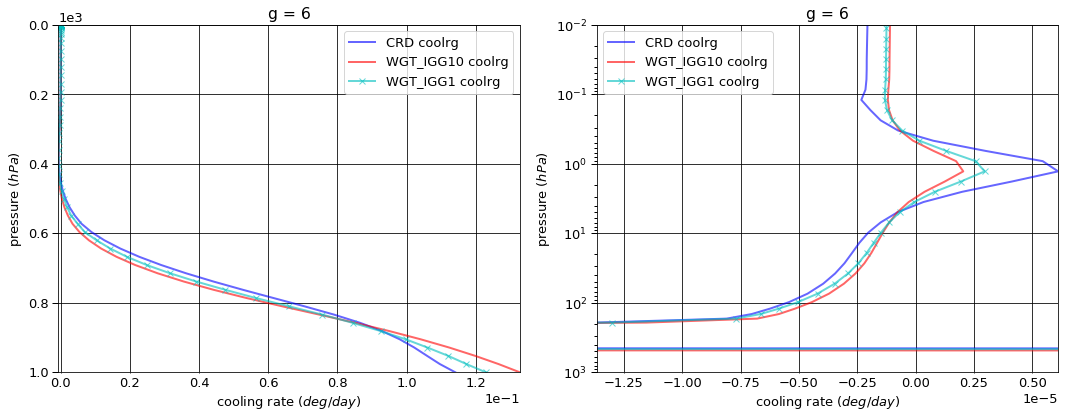

# Figure: cooling rate g-group 7

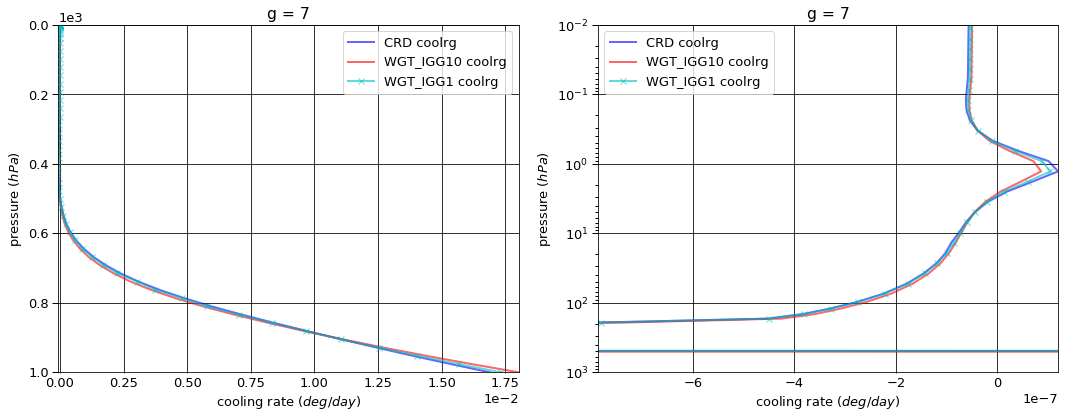

# Figure: cooling rate g-group total

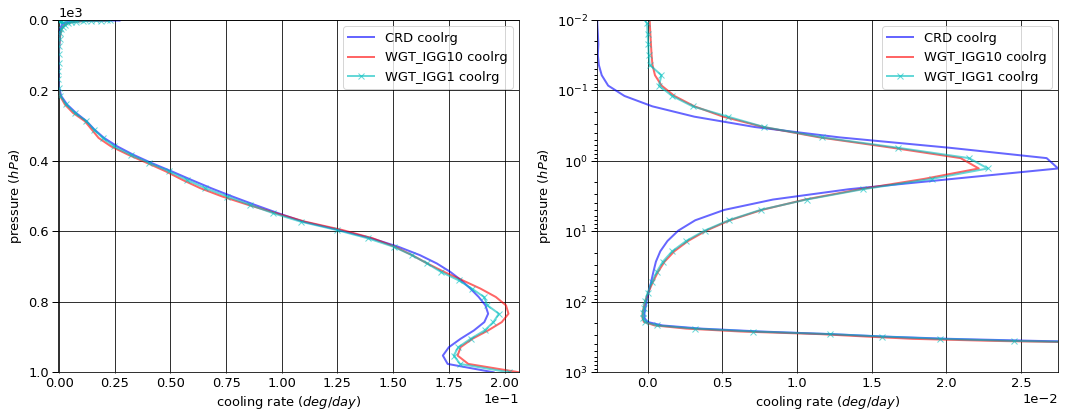

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024688  0.000000 -0.024688
  1013.0   76    -0.168881  0.168711 -0.000170
2 0.0      1     -0.131121  0.000000 -0.131121
  1013.0   76    -0.662861  0.662203 -0.000659
3 0.0      1     -0.550259  0.000000 -0.550259
  1013.0   76    -1.814341  1.812492 -0.001849
4 0.0      1     -2.223028  0.000000 -2.223028
  1013.0   76    -4.743623  4.716229 -0.027394
5 0.0      1     -4.733950  0.000000 -4.733950
  1013.0   76    -7.044017  6.679605 -0.364412
6 0.0      1     -6.311211  0.000000 -6.311211
  1013.0   76    -7.135319  4.075115 -3.060204
7 0.0      1     -2.123669  0.000000 -2.123669
  1013.0   76    -2.186133  0.400990 -1.785144


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023166  0.000000 -0.023166
  1013.0   76    -0.168881  0.168711 -0.000170
2 0.0      1     -0.124849  0.000000 -0.124849
  1013.0   76    -0.662861  0.662203 -0.000659
3 0.0      1     -0.535963  0.000000 -0.535963
  1013.0   76    -1.814341  1.812551 -0.001790
4 0.0      1     -2.203663  0.000000 -2.203663
  1013.0   76    -4.743623  4.722342 -0.021281
5 0.0      1     -4.774875  0.000000 -4.774875
  1013.0   76    -7.044017  6.827785 -0.216231
6 0.0      1     -6.430225  0.000000 -6.430225
  1013.0   76    -7.135319  3.917197 -3.218122
7 0.0      1     -2.127413  0.000000 -2.127413
  1013.0   76    -2.186133  0.396173 -1.789961


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023745  0.000000 -0.023745
  1013.0   76    -0.168881  0.168711 -0.000170
2 0.0      1     -0.124968  0.000000 -0.124968
  1013.0   76    -0.662861  0.662203 -0.000659
3 0.0      1     -0.536062  0.000000 -0.536062
  1013.0   76    -1.814341  1.812551 -0.001790
4 0.0      1     -2.199300  0.000000 -2.199300
  1013.0   76    -4.743623  4.718680 -0.024943
5 0.0      1     -4.756546  0.000000 -4.756546
  1013.0   76    -7.044017  6.778532 -0.265485
6 0.0      1     -6.377351  0.000000 -6.377351
  1013.0   76    -7.135319  3.949281 -3.186038
7 0.0      1     -2.124842  0.000000 -2.124842
  1013.0   76    -2.186133  0.399525 -1.786609


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.522070e-03  0.000000  1.522070e-03
  1013.0   76     0.000000e+00  0.000000 -2.710505e-20
2 0.0      1      6.271520e-03  0.000000  6.271520e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1      1.429616e-02  0.000000  1.429616e-02
  1013.0   76     0.000000e+00  0.000060  5.974760e-05
4 0.0      1      1.936450e-02  0.000000  1.936450e-02
  1013.0   76     0.000000e+00  0.006113  6.113232e-03
5 0.0      1     -4.092460e-02  0.000000 -4.092460e-02
  1013.0   76     0.000000e+00  0.148180  1.481803e-01
6 0.0      1     -1.190137e-01  0.000000 -1.190137e-01
  1013.0   76     8.881784e-16 -0.157917 -1.579175e-01
7 0.0      1     -3.744200e-03  0.000000 -3.744200e-03
  1013.0   76    -4.440892e-16 -0.004817 -4.816700e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      9.428150e-04  0.000000  9.428150e-04
  1013.0   76     0.000000e+00  0.000000 -2.710505e-20
2 0.0      1      6.152650e-03  0.000000  6.152650e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1      1.419697e-02  0.000000  1.419697e-02
  1013.0   76     0.000000e+00  0.000060  5.974760e-05
4 0.0      1      2.372790e-02  0.000000  2.372790e-02
  1013.0   76     0.000000e+00  0.002451  2.450690e-03
5 0.0      1     -2.259620e-02  0.000000 -2.259620e-02
  1013.0   76     0.000000e+00  0.098927  9.892665e-02
6 0.0      1     -6.614000e-02  0.000000 -6.614000e-02
  1013.0   76     8.881784e-16 -0.125834 -1.258336e-01
7 0.0      1     -1.173300e-03  0.000000 -1.173300e-03
  1013.0   76    -4.440892e-16 -0.001465 -1.464800e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.117187e-03
  1001.112500 75     6.081216e-05
2 0.000312    1     -3.576566e-04
  1001.112500 75     2.356525e-04
3 0.000312    1     -4.974889e-05
  1001.112500 75     6.659707e-04
4 0.000312    1     -5.213033e-05
  1001.112500 75     9.369564e-03
5 0.000312    1     -1.917236e-05
  1001.112500 75     5.381350e-02
6 0.000312    1     -1.974993e-06
  1001.112500 75     1.140724e-01
7 0.000312    1     -5.389859e-08
  1001.112500 75     1.689063e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.439162e-05
  1001.112500 75     6.081216e-05
2 0.000312    1     -5.217751e-05
  1001.112500 75     2.356525e-04
3 0.000312    1     -3.727570e-05
  1001.112500 75     6.401698e-04
4 0.000312    1     -3.109357e-05
  1001.112500 75     8.144385e-03
5 0.000312    1     -1.107649e-05
  1001.112500 75     4.675093e-02
6 0.000312    1     -1.044337e-06
  1001.112500 75     1.327280e-01
7 0.000312    1     -4.724007e-08
  1001.112500 75     1.802407e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.777494e-04
  1001.112500 75     6.081216e-05
2 0.000312    1     -4.592197e-05
  1001.112500 75     2.356525e-04
3 0.000312    1     -3.805663e-05
  1001.112500 75     6.401698e-04
4 0.000312    1     -3.317842e-05
  1001.112500 75     9.330210e-03
5 0.000312    1     -1.212212e-05
  1001.112500 75     5.159945e-02
6 0.000312    1     -1.191641e-06
  1001.112500 75     1.228887e-01
7 0.000312    1     -5.028414e-08
  1001.112500 75     1.731955e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.131578e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.054791e-04
  1001.112500 75     2.710505e-20
3 0.000312    1      1.247319e-05
  1001.112500 75    -2.580093e-05
4 0.000312    1      2.103676e-05
  1001.112500 75    -1.225179e-03
5 0.000312    1      8.095872e-06
  1001.112500 75    -7.062572e-03
6 0.000312    1      9.306558e-07
  1001.112500 75     1.865555e-02
7 0.000312    1      6.658520e-09
  1001.112500 75     1.133447e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.939437e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.117347e-04
  1001.112500 75     2.710505e-20
3 0.000312    1      1.169226e-05
  1001.112500 75    -2.580093e-05
4 0.000312    1      1.895191e-05
  1001.112500 75    -3.935390e-05
5 0.000312    1      7.050238e-06
  1001.112500 75    -2.214053e-03
6 0.000312    1      7.833518e-07
  1001.112500 75     8.816280e-03
7 0.000312    1      3.614454e-09
  1001.112500 75     4.289190e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.097926,0.000000,-16.097926
1013.0,76,-23.755176,18.515343,-5.239832



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.220154,0.000000,-16.220154
1013.0,76,-23.755176,18.506962,-5.248213



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.142815,0.000000,-16.142815
1013.0,76,-23.755176,18.489482,-5.265693



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.222282e-01,0.000000,-0.122228
1013.0,76,3.552714e-15,-0.008381,-0.008381



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.488917e-02,0.000000,-0.044889
1013.0,76,3.552714e-15,-0.025861,-0.025861


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003598
1001.112500,75,0.195109



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000118
1001.112500,75,0.206584



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000308
1001.112500,75,0.202075



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003480
1001.112500,75,0.011475



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003290
1001.112500,75,0.006966


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008442,0.006700
2,0.031667,0.026712
3,0.084558,0.073792
4,0.218406,0.193706
5,0.300933,0.294683
6,0.277224,0.307781
7,0.078770,0.096626


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.695655e-20
2,2.527212e-21
3,3.766568e-22
4,5.613710e-23
5,8.366699e-24
6,1.246977e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.695655e-20,NaN,0.008442,0.006700,0.008442,0.006700,600.0
2,2.527212e-21,0.14904,0.031667,0.026712,0.040109,0.033412,600.0
3,3.766568e-22,0.14904,0.084558,0.073792,0.124667,0.107205,600.0
4,5.613710e-23,0.14904,0.218406,0.193706,0.343073,0.300910,600.0
5,8.366699e-24,0.14904,0.300933,0.294683,0.644006,0.595593,600.0
6,1.246977e-24,0.14904,0.277224,0.307781,0.921230,0.903374,600.0
7,1.858499e-25,0.14904,0.078770,0.096626,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
